# Stock Return Prediction
#### by Filippo Dalla Chiara, 2020

This Jupyter Notebook contains my first (naive) trial to face the data challenge (2020) proposed by **QRT** (*Qube Research and Technology*) at **College de France**. Furthermore, it is a project for the course *''Python for Finance and Data Science''* at **ESILV**, that's why I was sometimes pedantic in explanations.\
\
The challenge consists in a typical **Machine Learning** (ML) problem of **classification**, in particular the goal is to predict the following-day movement (up/down) in the market of some stocks, in order to help strategic investment decisions.\
Provided data contain the historical data (returns and volumes) over a time range of 20 days and some categorical data that describe stocks.\
\
QRT also shares a public benchmark for accuracy, equals to **51.31%**, obtained by Random Forest, using the last-5-days data and the average return of stocks in the same ''sector'' for the last day.\
\
Links:\
https://www.college-de-france.fr/site/stephane-mallat/Challenges-2020.htm \
https://challengedata.ens.fr/challenges/23

Morover, this was my first real approach to **Neural Network** (NN) in Python and Keras, therefore most of my energy and time were spent on trying to understand how to build, set and tune a NN, than to really trying to improve the results. Since my lack of practical experience I face the problem by a *''trial and error''* approach, especially in the hyperparameters tuning of the NN.\
\
At the end I runned two classical classification algorithms (**Logistic Regression** and **Random Forest**) on the same features, just to make a comparison between test scores and check how good was my NN tuning.

## Import standard Python packages

In [252]:
# must-to-import packages for every project :)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time

In [253]:
# plot style
%matplotlib inline
sns.set_palette('BrBG') #('GnBu_d')
sns.set_style('whitegrid')

## Import dataset

In [254]:
x_train = pd.read_csv('_res/x_train.csv', index_col='ID')
y_train = pd.read_csv('_res/y_train.csv', index_col='ID')
# concatenate 'x' and 'y' to create a unique dataset
train = pd.concat([x_train, y_train], axis='columns')

# check / show dataset
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


#### Dataset composition
The dataset provided contains both categorical and categorical data, in particular:
- `DATE`, categorical data that group the rows in different trade days;
- `STOCK`, categorical data that identify an anonymous stock;
- `INDUSTRY`, `INDUSTRY_GROUP`, `SECTOR`, `SUB_INDUSTRY`, all categorical data that group the stocks relatively to the type of market;
- `VOLUME_{n}` of a stock relative to its past and the mean volume of other stocks;
- `RET_{n}`, performance of the stock relative to the market;
- `RET`, *bool* value that indicates the movement ''up'' or ''down'' relative to the median of the stocks in the same day, and it is the target **label** to predict from other data.

In [255]:
# show info about dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
DATE              418595 non-null int64
STOCK             418595 non-null int64
INDUSTRY          418595 non-null int64
INDUSTRY_GROUP    418595 non-null int64
SECTOR            418595 non-null int64
SUB_INDUSTRY      418595 non-null int64
RET_1             416236 non-null float64
VOLUME_1          353570 non-null float64
RET_2             416130 non-null float64
VOLUME_2          352209 non-null float64
RET_3             416088 non-null float64
VOLUME_3          350776 non-null float64
RET_4             416051 non-null float64
VOLUME_4          347598 non-null float64
RET_5             416011 non-null float64
VOLUME_5          343902 non-null float64
RET_6             415998 non-null float64
VOLUME_6          343881 non-null float64
RET_7             416010 non-null float64
VOLUME_7          344742 non-null float64
RET_8             415972 non-null float64
VOLUME_8          3

## Data cleaning
One of the first steps in data preprocessing is to manage with a incomplete or inconsistent dataset. Most of the ML algorithms is not able to work with missing data and so the need to remove incomplete rows/columns or possibly fill them.\
Firstly, one wants to visualize how much corrupted is the dataset and how missing data are distributed, in order to planify better cleaning strategy.

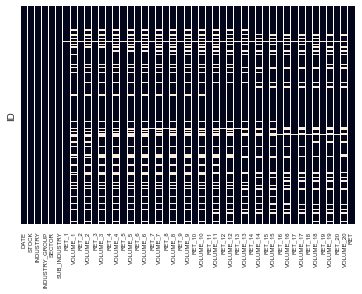

In [256]:
# check corruption of dataset
p = sns.heatmap(train.isnull(), yticklabels=False, xticklabels=True, cbar=False)
p.tick_params(labelsize=6)

As one can see in the previous plot, most of the missing values are in columns regarding "exchanging volumes".\
A strategy could be to fill the the missing values with the mean values for `VOLUME_{n}` for the same `INDUSTRY_GROUP` at the same `DATE`. This should infere at least the state of the the market for each sector at each date.

In [257]:
for COL in ['VOLUME_{}'.format(n+1) for n in range(20)]:
    train[COL] = train.groupby(['DATE', 'INDUSTRY_GROUP'])[COL].transform(lambda x: x.fillna(x.mean()))

For the other few missing data, one could notice that missing `RET_{n}` are mostly located in the same rows. Here the simplest strategy is to drop that lines, since infering that information would simply add "fake" data.

In [258]:
train.dropna(axis='index', inplace=True)

In [259]:
# check / debug
# train.info()

## Data visualization

Once the missing values are removed, one could really start to visualize the dataset and its characteristics. The first property of dataset I wanted to check is the balance of the classified labels. Here, labels in `RET` are computed in the following way:
- `True` if the return **overperformes** the **median** of all returns that day
- `False` if the return **underperformes** the **median** of all returns that day

This assures, by construction, a good balance in the entire dataset.\
One would maybe like to check the balance of labels between subsets of data, for instance grouped by `SECTOR` and `INDUSTRY_GROUP`. This could also reveals the presence of some correlation between that feature and the target label.

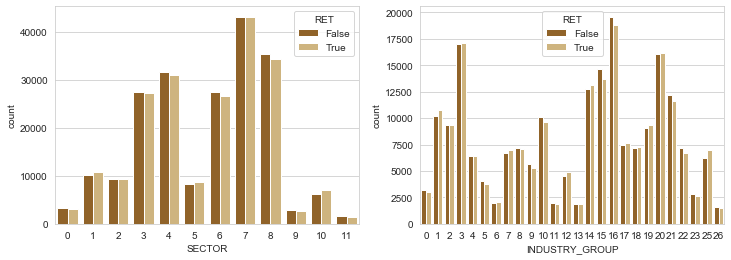

In [260]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
sns.countplot(x='SECTOR', hue='RET', data=train, ax=ax1)
sns.countplot(x='INDUSTRY_GROUP', hue='RET', data=train, ax=ax2)

As one can see from the previous plots, the labels `RET` are basically balanced even for subsets of the dataset, grouped by similarity. This shows that principle there's not any strong correlation between the `SECTOR`/`INDUSTRY_GROUP` and the movement in the market.

To define better the classification problem, I also wanted to visualize graphically numerical data in each row. The following plot shows the dynamics of returns and volumes for one stock in a range of 20 days and then movement (up or down) in the 21th day.

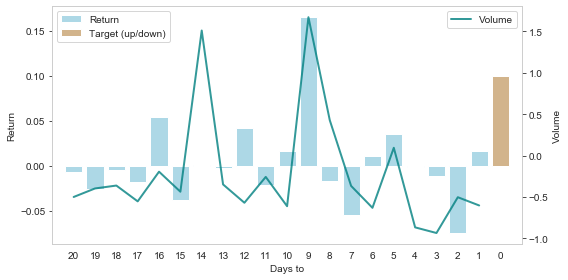

In [261]:
# plot one row of data
row_id = 24
x_range = np.arange(20, 0, -1)

# set plot
f, ax1 = plt.subplots(figsize=[8,4])
plt.xticks(range(20, -1, -1))
ax1.set_xlim(21, -1)
ax1.grid(False)
ax1.bar(x_range, train[['RET_{}'.format(n) for n in x_range]].loc[row_id], alpha=1, label='Return', color='lightblue')
ax1.bar(0, 0.1 if train['RET'].loc[row_id] else -0.1, alpha=1, label='Target (up/down)', color='tan')
ax1.set_xlabel('Days to')
ax1.set_ylabel('Return')
ax1.legend(loc=2)
# share x-axis
ax2 = ax1.twinx()
ax2.grid(False)
ax2.plot(x_range, train[['VOLUME_{}'.format(n) for n in x_range]].loc[row_id], alpha=.8, label='Volume', c='teal',
        linewidth=2)
ax2.set_ylabel('Volume')
ax2.legend(loc=1)
f.tight_layout()

#### Correlation matrix

(41.0, 0.0)

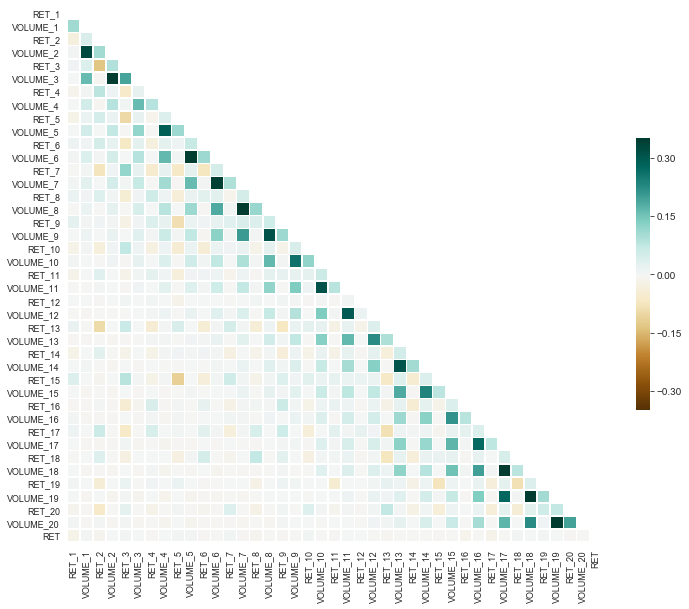

In [262]:
# compute the correlation matrix
corr_matrix = train.drop(columns=['DATE','STOCK','INDUSTRY','INDUSTRY_GROUP','SECTOR','SUB_INDUSTRY']).corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(12, 10))
p = sns.heatmap(corr_matrix, mask=mask, vmax=.35, vmin=-.35, center=0, square=True, linewidths=.5, cmap='BrBG',
                cbar_kws={"shrink": .5}, xticklabels=True, yticklabels=True)
p.tick_params(labelsize=9)

# fix seaborn/matplotlib bug that cuts the last row in the heatmap
bottom, top = p.get_ylim()
p.set_ylim(bottom+.5, top-.5)

Correlation matrix shows substantial absence of correlation between the single features with label `RET`. Only evident correlation appears between `VOLUME_{n}` in close days and between same-day `VOLUME_{n}` and `RET_{n}`.\
It's also evident that more is the time-interval between two data, less is their correlation, as expected.

## Feature engineering

Only historical data are traditionally not sufficient to predict the future movement in the market and even using good model, the forecasting power tends to be weak. For that reason, it's usefull to create compute other features to give as input to the ML algorithm.\
My choice fell to some classical to **technical indicators**, in particular:
- **Simple Moving Average** (MA) for no. of days equals to 7, 14
- **Exponential Moving Average** (EMA) for no. of days equals to 7, 14
- **Moving Average Convergence/Divergence**, i.e. the difference between the *short period* and the *long period* EMAs.
- **Historical volatility**, computed as standard deviation of returns over the all period of 20 days.

Furthermore, I computed the **average daily return** grouping the stocks by `SECTOR` and `INDUSTRY_GROUP`. However, since the two lines were very similar, I kept only the first one.

In [263]:
# set desidered moving averages to compute
N_MA = [7, 14]

# create moving-averages features
for N in N_MA:
    for shift in range(20-N):
        train['RET_MA{0}_{1}'.format(N, shift+1)] = train[['RET_{}'.format(n+shift+1) for n in range(N)]].mean(axis='columns')

In [264]:
# compute for-sector-average-at-date-returns features
for n in range(20):
    train['RET_IN_SECTOR_{}'.format(n+1)] = train.groupby(['DATE', 'SECTOR'])['RET_{}'.format(n+1)].transform(lambda x: x.mean())

# compute for-industry_group-average-at-date-returns features
for n in range(20):
    train['RET_IN_GROUP_{}'.format(n+1)] = train.groupby(['DATE', 'INDUSTRY_GROUP'])['RET_{}'.format(n+1)].transform(lambda x: x.mean())

In [265]:
# compute exponential moving averages
N_EMA = [7, 14]
for n_ema in N_EMA:
    alpha = 2 / (n_ema + 1)
    n = 19
    train['RET_EMA{}_19'.format(n_ema)] = train['RET_19'] * alpha + train['RET_20'] * (1-alpha)
    for n in range(18, 0, -1):
        train['RET_EMA{0}_{1}'.format(n_ema, n)] = train['RET_{}'.format(n)] * alpha \
                                                    + train['RET_EMA{0}_{1}'.format(n_ema, n+1)] * (1-alpha)
        

In [266]:
# compute moving average convergence/divergence 
for n in range(19):
    train['RET_MACD_{}'.format(n+1)] = train['RET_EMA{0}_{1}'.format(N_EMA[1], n+1)] \
                                       - train['RET_EMA{0}_{1}'.format(N_EMA[0], n+1)]

In [272]:
train['VOLATILITY'] = np.std(train[['RET_{}'.format(n+1) for n in range(20)]], axis=1)

## Features selection
In order not to introduce noise in the model, one could decide to take only a subset of the historical provided data.\
In this case I take only the information relative to the **previous 5 days** for the **returns**, **volumes** and all the **technical indicators**, plus the **historical volatility** over the all the 20-days time interval.

In [273]:
# set number of considered historical values
N_HIST = 5

# create list of features for model selection
features = []
features.append('VOLATILITY')
for n in range(N_HIST):
    features.append('RET_{}'.format(n+1))
    features.append('VOLUME_{}'.format(n+1))
    features.append('RET_IN_SECTOR_{}'.format(n+1))
    for n_ma in N_MA:
        if 20-n_ma > n:
            features.append('RET_MA{0}_{1}'.format(n_ma, n+1))
    for n_ema in N_EMA:
        if n+1 < 20:
            features.append('RET_EMA{0}_{1}'.format(n_ema, n+1))
    if n+1 < 20:   
        features.append('RET_MACD_{}'.format(n+1))

# check / visualize list of selected features
print('No. of featueres: {0}\n\nList of features:\n{1}'.format(len(features), features))

No. of featueres: 41

List of features:
['VOLATILITY', 'RET_1', 'VOLUME_1', 'RET_IN_SECTOR_1', 'RET_MA7_1', 'RET_MA14_1', 'RET_EMA7_1', 'RET_EMA14_1', 'RET_MACD_1', 'RET_2', 'VOLUME_2', 'RET_IN_SECTOR_2', 'RET_MA7_2', 'RET_MA14_2', 'RET_EMA7_2', 'RET_EMA14_2', 'RET_MACD_2', 'RET_3', 'VOLUME_3', 'RET_IN_SECTOR_3', 'RET_MA7_3', 'RET_MA14_3', 'RET_EMA7_3', 'RET_EMA14_3', 'RET_MACD_3', 'RET_4', 'VOLUME_4', 'RET_IN_SECTOR_4', 'RET_MA7_4', 'RET_MA14_4', 'RET_EMA7_4', 'RET_EMA14_4', 'RET_MACD_4', 'RET_5', 'VOLUME_5', 'RET_IN_SECTOR_5', 'RET_MA7_5', 'RET_MA14_5', 'RET_EMA7_5', 'RET_EMA14_5', 'RET_MACD_5']


## Data normalization and standardization
Data normalization is an important step in preprocessing to improve performance and speed in ML. Simplifying, it is used to reduce the distances in the space of data and adopting the same scale for all the dataset.

In [274]:
# before processing data I store the labels in the dependent variable to give as input to the learning model
y = train['RET'].values

In [275]:
from sklearn.preprocessing import StandardScaler

In [276]:
# preparing standardization and normalization
scaler = StandardScaler()
scaler.fit(train[features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [277]:
# store standardized and normalized features in the independent variable to five as input to learning model
X = scaler.fit_transform(train[features])

## Split training and test set
Before to perform the training, I keep part of the dataset to validate the model, testing the classification on it. Since the dataset is pretty huge, splitting in a classic 75-25 should be fine.

In [278]:
from sklearn.model_selection import train_test_split

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    random_state=24)

# Deep learning

## Import deep learning packages

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


## Neural network construction
After long-time tuning and many trials with different number of neurons, layers and various activation functions, the best performing structure that I found is the following:
- **input layer** using `tanh` activation function and no. of neurons comparable with the input size (= no. of features);
- **3 hidden layers**;
- first huge hidden layers, made by **150 neurons** and **33% dropout**, this is to prevent overfitting, that affects the NN with a large no. of neurons per layer;
- first layer uses `tanh` activation function;
- second and third hidden layers built by **50** and **35 neurons**, respectively;
- second and third hidden layers use `relu` activation function;
- **output layer** using `sigmoid` activation function and 1-dimensional output, as typical for classication problems.

In [61]:
# build model
model = Sequential()
model.add(Dense(50, input_dim=len(features), activation='tanh'))
model.add(Dense(150, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(50, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Choices for **loss function** and **metrics** fall on classical `binary_crossentropy` and `accuracy`, respectively. As for the optimizer, I found **ADAM** (`adam`) as the faster to converge and best performing than **Stochastic Gradient Descent**.

In [64]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training network
Last hyperparameters to choose are the `epoch` and `batch_size`. The choice falls on **250 epochs** and a **batch size** of **5000**, also considering the characteristics of my laptop (i5, 4core, RAM 4GB).\
\
**Warning!** Training could take ~ 10 mins

In [65]:
t_0 = time.time()
model.fit(X_train, y_train, epochs=250, batch_size=5000)
print('\nElapsed time: {} s'.format(time.time() - t_0))

Epoch 1/250
309351/309351 [==============================] - 3s 11us/step - loss: 0.6914 - accuracy: 0.5218
Epoch 2/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6902 - accuracy: 0.5268
Epoch 3/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6892 - accuracy: 0.5321
Epoch 4/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6884 - accuracy: 0.5333
Epoch 5/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6877 - accuracy: 0.5362
Epoch 6/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6868 - accuracy: 0.5393
Epoch 7/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6860 - accuracy: 0.5412
Epoch 8/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6856 - accuracy: 0.5420
Epoch 9/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6850 - accuracy: 0.5447
Epoch 10/250
309351/309351 [========

309351/309351 [==============================] - 3s 9us/step - loss: 0.6692 - accuracy: 0.5810
Epoch 77/250
309351/309351 [==============================] - 3s 8us/step - loss: 0.6696 - accuracy: 0.5804
Epoch 78/250
309351/309351 [==============================] - 3s 8us/step - loss: 0.6693 - accuracy: 0.5806
Epoch 79/250
309351/309351 [==============================] - 3s 8us/step - loss: 0.6693 - accuracy: 0.5811
Epoch 80/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6690 - accuracy: 0.5817
Epoch 81/250
309351/309351 [==============================] - 3s 8us/step - loss: 0.6689 - accuracy: 0.5813
Epoch 82/250
309351/309351 [==============================] - 3s 8us/step - loss: 0.6690 - accuracy: 0.5821
Epoch 83/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6690 - accuracy: 0.5820
Epoch 84/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6689 - accuracy: 0.5817
Epoch 85/250
309351/309351 [=============

309351/309351 [==============================] - 3s 9us/step - loss: 0.6645 - accuracy: 0.5892
Epoch 152/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6643 - accuracy: 0.5903
Epoch 153/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6645 - accuracy: 0.5892
Epoch 154/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6641 - accuracy: 0.5900
Epoch 155/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6641 - accuracy: 0.5900
Epoch 156/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6639 - accuracy: 0.5907
Epoch 157/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6639 - accuracy: 0.5901
Epoch 158/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6643 - accuracy: 0.5896
Epoch 159/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6641 - accuracy: 0.5894
Epoch 160/250
309351/309351 [====

309351/309351 [==============================] - 3s 9us/step - loss: 0.6616 - accuracy: 0.5938
Epoch 226/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6616 - accuracy: 0.5936
Epoch 227/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6613 - accuracy: 0.5956
Epoch 228/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6612 - accuracy: 0.5943: 1s
Epoch 229/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6613 - accuracy: 0.5936
Epoch 230/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6608 - accuracy: 0.5959
Epoch 231/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6614 - accuracy: 0.5949
Epoch 232/250
309351/309351 [==============================] - 3s 9us/step - loss: 0.6611 - accuracy: 0.5945
Epoch 233/250
309351/309351 [==============================] - 3s 10us/step - loss: 0.6613 - accuracy: 0.5939
Epoch 234/250
309351/309351 

## Testing network
In order to test the NN one need to perform prediction with the already trained model on another set, not used in learning process. This is also to check the presence of *overfitting* phenomena, that bring to good performance on the train observations, but lack of generalization in unseen input data.

In [66]:
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
y_predict = model.predict(X_test)

In [68]:
# 'predict_classes' method returns class with format [0]-[1]
y_predict = model.predict_classes(X_test)
# transform to bool to compare with y_test
y_predict = [True if j==[1] else False for j in y_predict]

#### Classification report

In [69]:
print(classification_report(y_test, y_predict, digits=5))

              precision    recall  f1-score   support

       False    0.57279   0.59626   0.58429     51627
        True    0.57784   0.55411   0.56573     51490

    accuracy                        0.57521    103117
   macro avg    0.57532   0.57518   0.57501    103117
weighted avg    0.57531   0.57521   0.57502    103117



#### Confusion matrix

(2.0, 0.0)

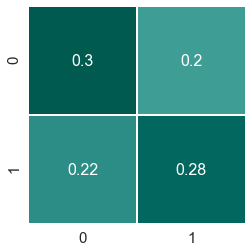

In [132]:
conf_matrix = confusion_matrix(y_test, y_predict)
p = sns.heatmap(conf_matrix / np.sum(conf_matrix), vmax=.35, vmin=.10, center=0, square=True, linewidths=.5,
                annot=True, annot_kws={'size': 16}, cbar=False, cmap='BrBG')
p.tick_params(labelsize=15)
bottom, top = p.get_ylim()
p.set_ylim(bottom+.5, top-.5)

# Comparison with classical models
In order to evaluate the goodness of the previews network, one could compare its performance against other models.

## Logistic Regression
Logit il probably the simplest native model for binary classification, and usually the first one used facing a Machine Learning problem from scratch (following *Occam Razor principle*).\
In this case it's just presented without any expectation, since the problem is clearly to complex for this algorithm.

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
# learn
lr = LogisticRegression().fit(X_train, y_train)

In [73]:
# test
y_lr_predict = lr.predict(X_test)

#### Classification report

In [74]:
print(classification_report(y_test, y_lr_predict, digits=5))

              precision    recall  f1-score   support

       False    0.51597   0.51190   0.51393     51627
        True    0.51444   0.51851   0.51647     51490

    accuracy                        0.51520    103117
   macro avg    0.51521   0.51521   0.51520    103117
weighted avg    0.51521   0.51520   0.51520    103117



#### Confusion matrix

(2.0, 0.0)

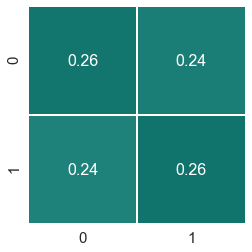

In [134]:
# compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_lr_predict)

# plot confusion matrix
p = sns.heatmap(conf_matrix / np.sum(conf_matrix), vmax=.35, vmin=.10, center=0, square=True, linewidths=.5,
                annot=True, annot_kws={"size": 16}, cbar=False, cmap='BrBG')
p.tick_params(labelsize=15)

# fix matplotlib/seaborn bug
bottom, top = p.get_ylim()
p.set_ylim(bottom+.5, top-.5)

As expected, even if training is really fast, results are quite poor and `accuracy` is only a little greater than 51% and Logistic Regression confirms not to be adapt to learn the complexity of this problem.

## Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

Here the learning model is build by **200 trees**, while **max depth** is set to **15 nodes**, in order to prevent overfitting and limit the learning time.\
\
**Warning!** Training could take ~ 10 mins

In [84]:
# model definition
rf = RandomForestClassifier(n_estimators=200, max_depth=15)

# learn
t_0 = time.time()
rf.fit(X_train, y_train)
print('Elapsed time: {} s'.format(time.time() - t_0))

Elapsed time: 657.3899207115173 s


In [85]:
# test
y_rf_predict = rf.predict(X_test)

#### Classification report

In [86]:
print(classification_report(y_test, y_rf_predict, digits=5))

              precision    recall  f1-score   support

       False    0.57445   0.57962   0.57702     51627
        True    0.57466   0.56947   0.57205     51490

    accuracy                        0.57455    103117
   macro avg    0.57455   0.57454   0.57454    103117
weighted avg    0.57455   0.57455   0.57454    103117



#### Confusion matrix

(2.0, 0.0)

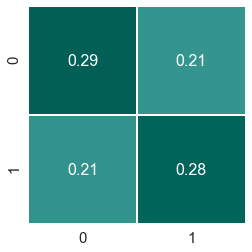

In [135]:
# compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_rf_predict)

# plot confusion matrix
p = sns.heatmap(conf_matrix / np.sum(conf_matrix), vmax=.35, vmin=.10, center=0, square=True, linewidths=.5,
                annot=True, annot_kws={"size": 16}, cbar=False, cmap='BrBG')
p.tick_params(labelsize=15)

# fix matplotlib/seaborn bug
bottom, top = p.get_ylim()
p.set_ylim(bottom+.5, top-.5)

# Final thoughts

Both the accuracy scores for **Neural Network** and **Random Forest** overperformed the benchmark.\
In particular Random Forest used was built by less trees than the one used as benchmark (200 trees against 500), that confirms the good choice made in feature engineering.\
Results for Random Forest and Neural Network are comparable, both in score and learning time, even after a *newbie* tuning of the network. This makes me believe that, with more experience and trials, deep learning could reach much better results and performances.

### Trading strategy simulation
I simulated a *long/short strategy*, i.e. a classical trading strategy when one takes a long position in a stock that is expected to increase in value and a short position in stock that is expected to decrease, by this way one can gain from both the daily market movements of a stock.\
For semplicity, I assumed to gain +1 in case of right prediction on the following-day movement and to lose -1 if model does wrong.\
I simulated the strategy for 100 trading days and plotted the performances over time for each trained algorithm.

In [249]:
from sklearn.metrics import accuracy_score

# simulation parameters
N_SIMU = 1000
N_DAYS = 100

# get accuracy
nn_accuracy = accuracy_score(y_test, y_predict) # neural network
rf_accuracy = accuracy_score(y_test, y_rf_predict) # random forest
lr_accuracy = accuracy_score(y_test, y_lr_predict) # logistic regression

# initialize strategy results
nn_strategy = np.zeros(N_DAYS)
rf_strategy = np.zeros_like(nn_strategy)
lr_strategy = np.zeros_like(nn_strategy)

# simulate
for i in range(N_SIMU):
    tmp_nn_strategy = []
    tmp_rf_strategy = []
    tmp_lr_strategy = []
    for d in range(N_DAYS):
        tmp_nn_strategy.append(+1 if nn_accuracy > np.random.random() else -1)
        tmp_rf_strategy.append(+1 if rf_accuracy > np.random.random() else -1)
        tmp_lr_strategy.append(+1 if lr_accuracy > np.random.random() else -1)
    # comulative sum
    nn_strategy += np.cumsum(tmp_nn_strategy)
    rf_strategy += np.cumsum(tmp_rf_strategy)
    lr_strategy += np.cumsum(tmp_lr_strategy)
    
# compute average performance
nn_strategy /= N_SIMU
rf_strategy /= N_SIMU
lr_strategy /= N_SIMU

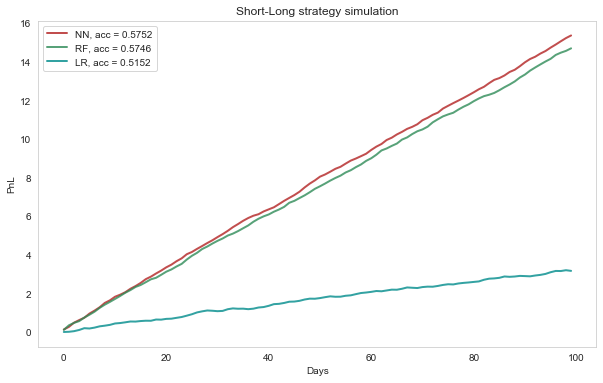

In [251]:
# plot simulation
f = plt.figure(figsize=[10,6])
plt.grid(False)
plt.plot(range(N_DAYS), nn_strategy, label='NN, acc = {:1.4f}'.format(nn_accuracy), linewidth=2, alpha=.8, c='firebrick')
plt.plot(range(N_DAYS), rf_strategy, label='RF, acc = {:1.4f}'.format(rf_accuracy), linewidth=2, alpha=.8, c='seagreen')
plt.plot(range(N_DAYS), lr_strategy, label='LR, acc = {:1.4f}'.format(lr_accuracy), linewidth=2, alpha=.8, c='darkcyan')
plt.title('Short-Long strategy simulation')
plt.xlabel('Days')
plt.ylabel('PnL')
plt.legend()